# Hotel Booking Demand

## By: John Rooney, Michael Sebring, and Jonathan Lynch

__Data set description:__

This data set contains booking information from two different hotels, a resort hotel and a city hotel located in Portugal. The resort hotel is located in the region of Algarve and the city hotel is located in the city of Lisbon. The data includes information such as when the booking was made, the length of stay, the number of adults, children, and/or babies, the number of available parking spaces, customer type, whether the booking was cancelled, guest country of origin, average daily rate, etc.  All of the bookings were due to arrive between July 1, 2015 and August 31, 2017.  The data set can be obtained at: https://www.kaggle.com/jessemostipak/hotel-booking-demand#

__Import libraries and read in file:__

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold
from sklearn import neighbors, tree, naive_bayes
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as plt

#%cd "/Users/jonathanlynch/Desktop/DSC 478"

pd.set_option('display.max_columns', None)   # change view to see all attributes
data = pd.read_csv("hotel_bookings.csv")

data.head(10)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
6,Resort Hotel,0,0,2015,July,27,1,0,2,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,NaN,NaN,0,Transient,107.0,0,0,Check-Out,2015-07-03
7,Resort Hotel,0,9,2015,July,27,1,0,2,2,0.0,0,FB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,303.0,NaN,0,Transient,103.0,0,1,Check-Out,2015-07-03
8,Resort Hotel,1,85,2015,July,27,1,0,3,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,82.0,0,1,Canceled,2015-05-06
9,Resort Hotel,1,75,2015,July,27,1,0,3,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,15.0,NaN,0,Transient,105.5,0,0,Canceled,2015-04-22


In [2]:
data.shape  # look at size of dataset

(119390, 32)

## Preprocess Data:

__Take a look at the data types:__

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

At first glance, it appears that there are 12 categorical variables.  However, the variables is_canceled, is_repeated_guest, and agent (represented by travel agency ID) are really categorical in nature but are already represented as numbers. The last column, reservation_status_date, is an ordinal attribute, but in most cases is identical to the arrival date.

__Check for missing values:__

In [4]:
data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

__Replace missing values:__

In [5]:
# for missing children values, assume zero children
# if travel agency is missing, replace with zero (customer most likely did not use a booking agent)
# if is company missing, replace with zero (most likely was private)

null_replacements = {"children": 0.0, "agent": 0, "company": 0}

data = data.fillna(null_replacements)

__Replace all meal values listed as 'Undefined' with 'SC':__

In [6]:
data['meal'].replace('Undefined', 'SC', inplace=True)  # dataset detail mentions these are the same

__Drop rows that have values of 0 adults, 0 children, and 0 babies listed (no guests):__

In [7]:
# some rows have zero guests listed: drop these observations

no_guests = list(data.loc[data['adults']
                   + data['children']
                   + data['babies']==0].index)

data.drop(data.index[no_guests], inplace=True)

In [8]:
data.shape   # see how many rows were removed

(119210, 32)

## Explore Data (EDA):

## Create Dummy Variables & Standardize Data:

__Change all categorical variables to numeric values:__

In [9]:
hotel_num = {'Resort Hotel': 0, 'City Hotel': 1}
data = data.replace(hotel_num)

month_num = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
data = data.replace(month_num)

meal_num = {'BB': 0, 'FB': 1, 'HB': 2, 'SC': 3}
data = data.replace(meal_num)

market_num = {'Aviation': 0, 'Corporate': 1, 'Direct': 2, 'Undefined': 3, 'Groups': 4, 'GDS': 4, 'TA/TO': 5, 'Offline TA/TO': 5, 'Online TA': 6, 'Complementary': 7}
data = data.replace(market_num)

room_num = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 9, 'K': 10, 'L': 8}
data = data.replace(room_num)

deposit_num = {'No Deposit': 0, 'Non Refund': 1, 'Refundable': 2}
data = data.replace(deposit_num)

customer_num = {'Contract': 0, 'Group': 1, 'Transient': 2, 'Transient-Party': 3}
data = data.replace(customer_num)

reservation_num = {'Canceled': 0, 'Check-Out': 1, 'No-Show': 2}
data = data.replace(reservation_num)

__Drop unnecessary variables:__ 

In [10]:
data = data.drop('company', 1)    # drop company variable (94% of items missing for this column)
data = data.drop('reservation_status_date', 1)   # drop reservation_status_date (essentially the same as arrival date)
data = data.drop('country', 1)    # drop country

In [11]:
data

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status
0,0,0,342,2015,7,27,1,0,0,2,0.0,0,0,2,2,0,0,0,2,2,3,0,0.0,0,2,0.00,0,0,1
1,0,0,737,2015,7,27,1,0,0,2,0.0,0,0,2,2,0,0,0,2,2,4,0,0.0,0,2,0.00,0,0,1
2,0,0,7,2015,7,27,1,0,1,1,0.0,0,0,2,2,0,0,0,0,2,0,0,0.0,0,2,75.00,0,0,1
3,0,0,13,2015,7,27,1,0,1,1,0.0,0,0,1,1,0,0,0,0,0,0,0,304.0,0,2,75.00,0,0,1
4,0,0,14,2015,7,27,1,0,2,2,0.0,0,0,6,5,0,0,0,0,0,0,0,240.0,0,2,98.00,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,1,0,23,2017,8,35,30,2,5,2,0.0,0,0,5,5,0,0,0,0,0,0,0,394.0,0,2,96.14,0,0,1
119386,1,0,102,2017,8,35,31,2,5,3,0.0,0,0,6,5,0,0,0,4,4,0,0,9.0,0,2,225.43,0,2,1
119387,1,0,34,2017,8,35,31,2,5,2,0.0,0,0,6,5,0,0,0,3,3,0,0,9.0,0,2,157.71,0,4,1
119388,1,0,109,2017,8,35,31,2,5,2,0.0,0,0,6,5,0,0,0,0,0,0,0,89.0,0,2,104.40,0,0,1


In [82]:
#categorical vars
cats = ['agent', 'arrival_date_year', 'arrival_date_day_of_month', 'arrival_date_week_number', 'arrival_date_month', 'is_repeated_guest', 'distribution_channel', 'is_canceled', 'hotel', 'meal', 'market_segment', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status']
#continuous vars
cont = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']

## Continuous Variables

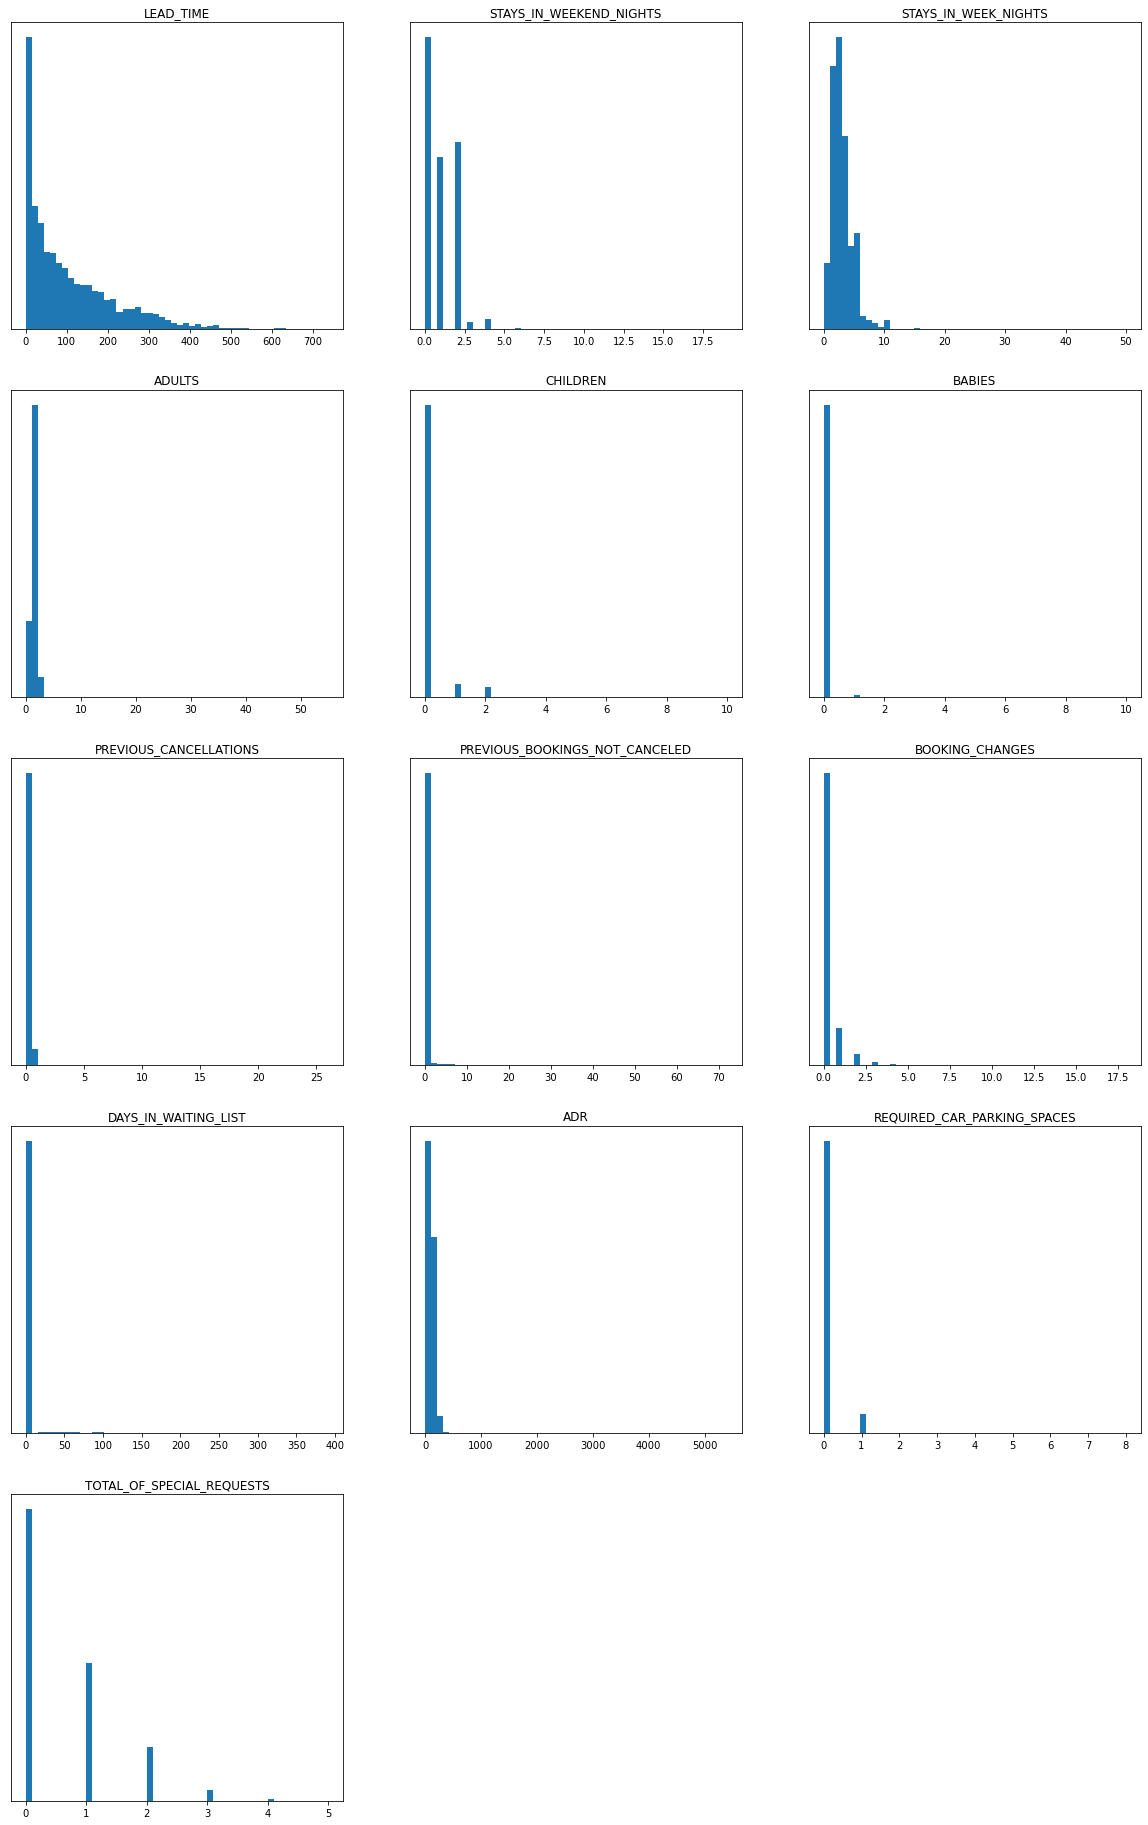

In [98]:
fig, ax = plt.subplots(figsize=(16, 25))
ax.axis('off')
fig.tight_layout()
for idx, i in enumerate(cont):
    fig.add_subplot(5,3,idx+1)
    plt.hist(data[i], bins = 50)
    plt.yticks([])
    plt.title(i.upper())

We can see from the histograms above that most of our continuous variables are highly skewed to the right. We will have to attempt to normalize these

#### Showing Percentage of top 5 most common values in continuous variables


In [85]:
for i in cont:
    print(i.upper())
    print(data[i].value_counts(normalize=True)[:5]*100)
    print()

LEAD_TIME
0    5.254593
1    2.889858
2    1.732237
3    1.522523
4    1.434443
Name: lead_time, dtype: float64

STAYS_IN_WEEKEND_NIGHTS
0    43.532422
2    27.905377
1    25.681570
4     1.549367
3     1.050247
Name: stays_in_weekend_nights, dtype: float64

STAYS_IN_WEEK_NIGHTS
2    28.244275
1    25.410620
3    18.656992
5     9.284456
4     8.005201
Name: stays_in_week_nights, dtype: float64

ADULTS
2    75.228588
1    19.316333
3     5.202584
0     0.187065
4     0.052009
Name: adults, dtype: float64

CHILDREN
0.0    92.794229
1.0     4.077678
2.0     3.063501
3.0     0.063753
Name: children, dtype: float64

BABIES
0     99.230769
1      0.754970
2      0.012583
10     0.000839
9      0.000839
Name: babies, dtype: float64

PREVIOUS_CANCELLATIONS
0     94.565053
1      5.073400
2      0.095630
3      0.054526
24     0.040265
Name: previous_cancellations, dtype: float64

PREVIOUS_BOOKINGS_NOT_CANCELED
0    96.969214
1     1.290160
2     0.486536
3     0.279339
4     0.192098
Name: pr

Children, babies, previous_cancelations, previous_bookings_not_cancelled, days_in_waiting_list, required_parking_spaces all have >90% of instances in most common value (babies > 99%). Should consider which are useful

### Correlation map for continuous variables

<AxesSubplot:>

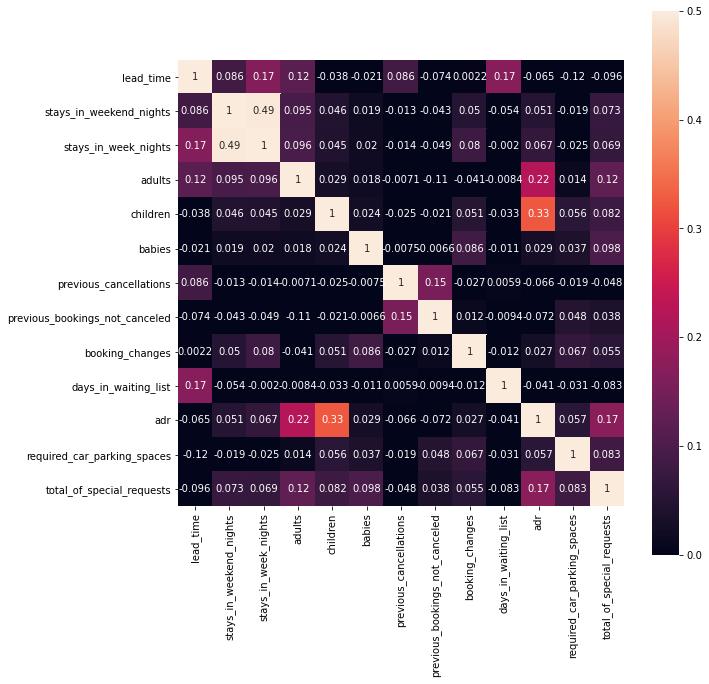

In [169]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data[cont].corr(), annot=True, square=True, vmin=0, vmax=0.5)

- Highest correlation is 0.49
- Few variable pairs have correlation above 0.1

### Print variable pairs with correlation values over threshold

In [171]:
corr = data[cont].corr()
high = []
thresh = 0.1 # threshhold
for i in range(corr.shape[0]):
    for a in range(corr.shape[1]):
        if (corr.iloc[i,a] > thresh and corr.iloc[i,a] != 1) or\
            (corr.iloc[i,a] < -thresh and corr.iloc[i,a] != 1):
            high.append(sorted([corr.index[i], corr.index[a]]))
high2 = []
for i in high:
    if i not in high2:
        high2.append(i)
for i in sorted(high2):
    print(i)
    print()

['adr', 'adults']

['adr', 'children']

['adr', 'total_of_special_requests']

['adults', 'lead_time']

['adults', 'previous_bookings_not_canceled']

['adults', 'total_of_special_requests']

['days_in_waiting_list', 'lead_time']

['lead_time', 'required_car_parking_spaces']

['lead_time', 'stays_in_week_nights']

['previous_bookings_not_canceled', 'previous_cancellations']

['stays_in_week_nights', 'stays_in_weekend_nights']



## Categorical Variables

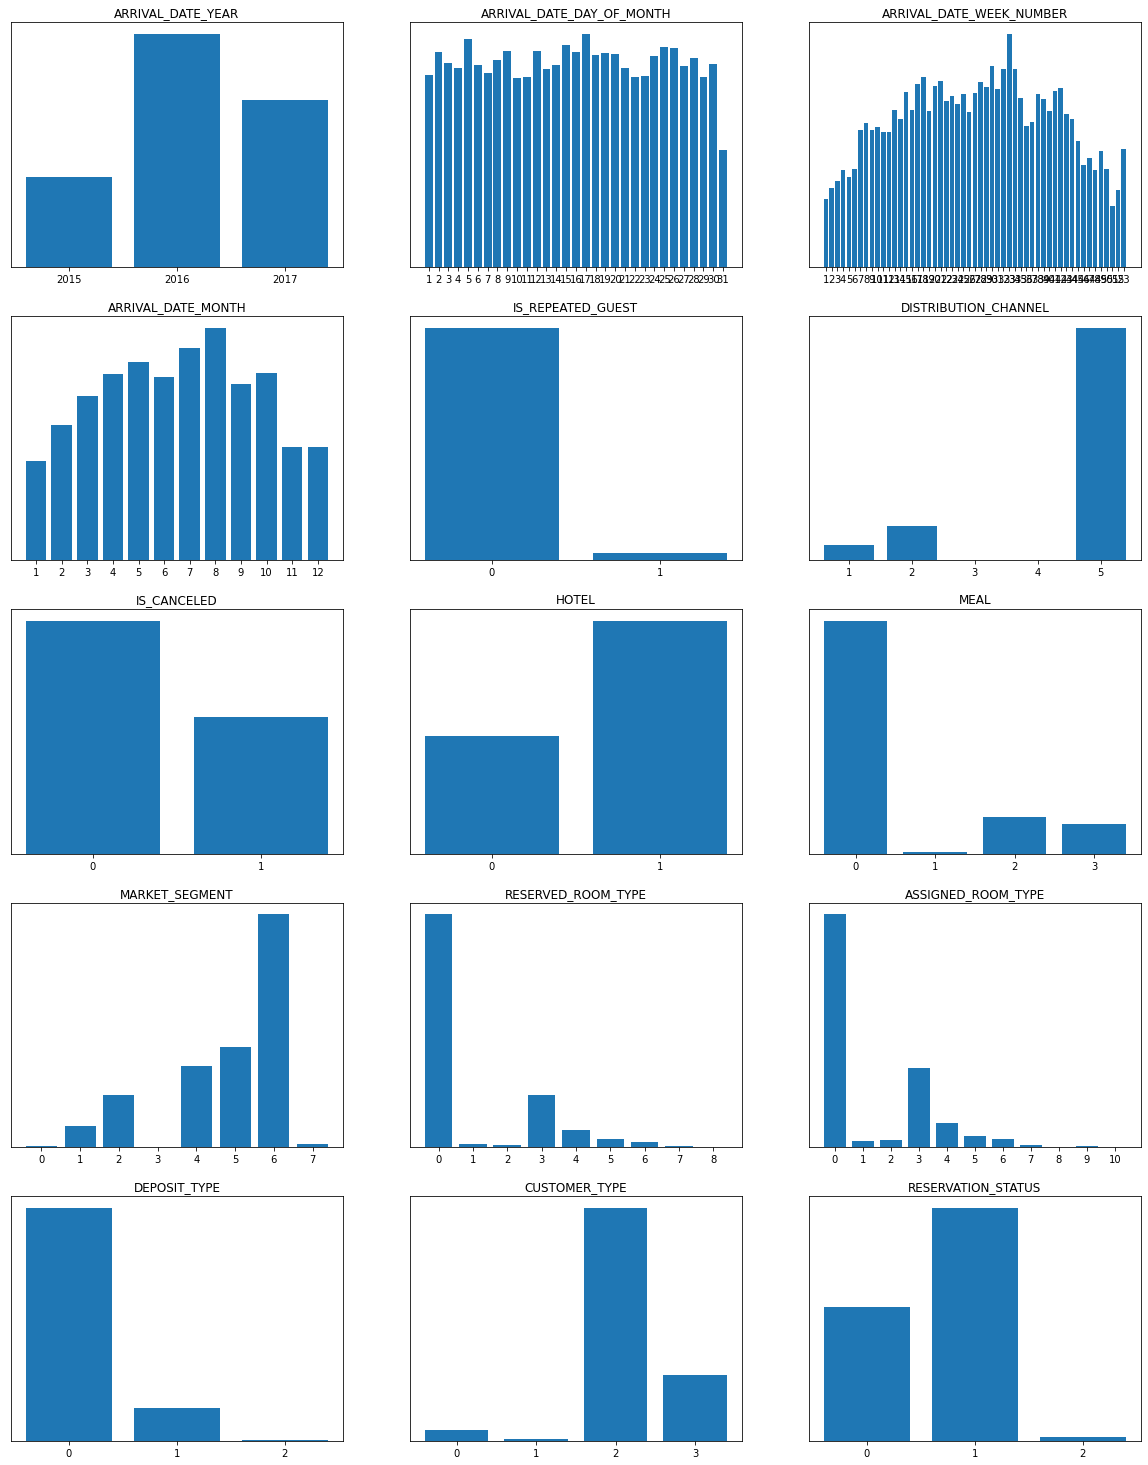

In [52]:
fig, ax = plt.subplots(figsize=(16, 20))
ax.axis('off')
fig.tight_layout()
for idx, i in enumerate(cats):
    labels = list(data[i].value_counts().index)
    values = list(data[i].value_counts())
    fig.add_subplot(5,3,idx+1)
    plt.bar(labels, values)
    plt.xticks(labels)
    plt.yticks([])
    plt.title(i.upper())

Z:\jmroo\Anaconda\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='adr', ylabel='Density'>

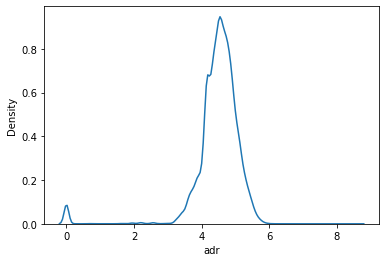

In [173]:
sns.kdeplot(np.log(data.adr+1))